# Data Science Methods for Clean Energy Research 
## _Neural Networks_

## Outline

### 1. Load dataset & rescale
### 2. Build a NN model with Keras
### 3. Train NN and test
### 4. Increase complexity of NN

In [1]:
# Import plotting libraries
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.size': 22})

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set larger fontsize for all plots
%load_ext autoreload
%autoreload 2


In [2]:
import tqdm
from tqdm.keras import TqdmCallback

### 1. Loading the data, splitting into train and test and rescaling

Set our random seed so that all computations are deterministic

In [9]:
seed = 42

Read in the raw data for the HCEPDB into a pandas dataframe

In [3]:
df = pd.read_csv('datasets/HCEPDB_moldata.csv')
df.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1
1,1245190,C1C=CC=C1c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH2]...,C22H15NSeSi,400.4135,5.261398,0.504824,160.401549,-5.104824,1.630750,-3.474074,C1=CC=C(C1)c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH...
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1


In [4]:
df_smaller = df.sample(frac=0.05)

In [5]:
df_smaller.describe()

,id,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha
count,1.161420e+05,116142.000000,116142.000000,116142.000000,116142.000000,116142.000000,116142.000000,116142.000000
mean,1.330921e+06,415.409470,3.911113,0.551546,120.193114,-5.173573,1.882984,-3.290589
std,8.599451e+05,59.902706,2.508747,0.304042,66.863919,0.303396,0.401333,0.391730
min,3.000000e+00,169.225900,0.000000,0.000000,0.000000,-7.512315,0.727928,-5.923459
25%,6.080620e+05,378.453600,2.043776,0.342425,69.223461,-5.368137,1.588553,-3.586256
50%,1.227040e+06,415.559700,3.404343,0.539960,110.994282,-5.157940,1.869157,-3.279007
75%,1.989246e+06,456.684400,5.592669,0.749894,162.744361,-4.966250,2.162671,-3.003364
max,3.102817e+06,640.453100,11.117424,2.007061,383.947211,-4.051151,3.531577,-1.173109


Separate out the input features from the output target `'pce'`

In [6]:
X = df_smaller[['mass', 'voc', 'jsc', 'e_homo_alpha', 'e_gap_alpha', 
        'e_lumo_alpha']].values
Y = df_smaller[['pce']].values

Let's create the test / train split from this data and keep 20% for testing.  

In [10]:
X_train_pn, X_test_pn, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    random_state=seed)

Now we need rescale the input features of the training set using the `StandardScaler()` class [more info](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and store the scaler to use it for the future test sets. We are rescaling input features because we do not want one of the input features to matter more than the others.

In [11]:
# create the scaler from the training data only and keep it for later use
X_train_scaler = StandardScaler().fit(X_train_pn)
# apply the scaler transform to the training data
X_train = X_train_scaler.transform(X_train_pn)

Now let's reuse that scaler transform on the test set.  This way we never contaminate the test data with the training data.  We'll start with a histogram of the testing data just to prove to ourselves it is working.

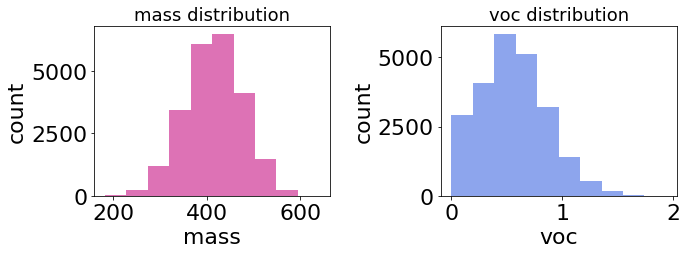

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(X_test_pn[:,0], alpha=0.6, color='mediumvioletred')
ax[0].set_xlabel('mass')
ax[0].set_ylabel('count')
ax[0].set_title('mass distribution',fontsize=18)
ax[1].hist(X_test_pn[:,1], alpha=0.6, color='royalblue')
ax[1].set_xlabel('voc')
ax[1].set_ylabel('count')
ax[1].set_title('voc distribution',fontsize=18)
plt.tight_layout()
plt.show()

OK, now apply the training scaler transform to the test and plot a histogram

In [13]:
X_test = X_train_scaler.transform(X_test_pn)

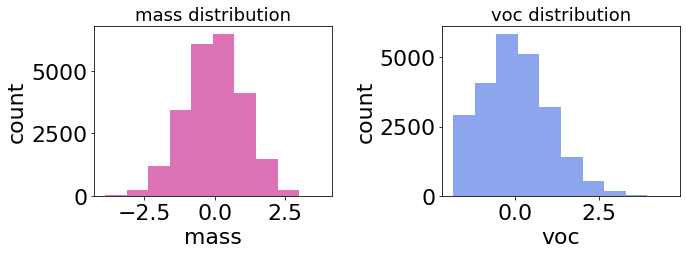

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(X_test[:,0], alpha=0.6, color='mediumvioletred')
ax[0].set_xlabel('mass')
ax[0].set_ylabel('count')
ax[0].set_title('mass distribution',fontsize=18)
ax[1].hist(X_test[:,1], alpha=0.6, color='royalblue')
ax[1].set_xlabel('voc')
ax[1].set_ylabel('count')
ax[1].set_title('voc distribution',fontsize=18)
plt.tight_layout()
plt.show()

### 2. Creating the neural network model

This is a simple neural network with one hidden layer and one output layer. Here we will use `Keras` functions [Keras documentation](https://keras.io/guides/). We will use `Dense` layers as defined [here](https://keras.io/api/layers/core_layers/dense/), and the `Adam` [optimizer](https://keras.io/api/optimizers/adam/) which relies on gradient descent.

In [31]:
def simple_network():
    # assemble the structure
    model = Sequential()
    # Note - THIS IS YOUR FIRST HIDDEN LAYER - input layer is defined by input_dim!
    model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    # This is the output layer
    model.add(Dense(1, kernel_initializer='normal'))
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [25]:
my_model = simple_network()
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 15)                105       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### 3. Training the NN

Train the neural network with the following

In [26]:
# initialize the random number generator - i.e. get reproducible starting weights
np.random.seed(seed)
# create the NN framework
estimator = KerasRegressor(build_fn=simple_network,
        epochs=150, batch_size=10000, verbose=0)
history = estimator.fit(X_train, y_train, validation_split=0.33, epochs=150, 
        batch_size=10000, verbose=0, callbacks=TqdmCallback(verbose=0))

The history object returned by the `fit` call contains the information in a fitting run.

In [27]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [28]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

final MSE for train is 0.15 and for validation is 0.15


Let's plot it!

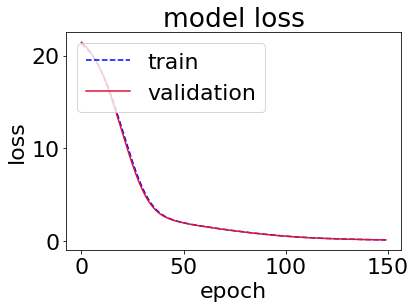

In [29]:
# summarize history for loss
plt.plot(history.history['loss'], '--', c='b')
plt.plot(history.history['val_loss'], c='crimson')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Let's get the MSE for the test set.

In [30]:
test_loss = estimator.model.evaluate(X_test, y_test)
print("test set mse is %.2f" % test_loss)

726/726 [==============================] - 0s 479us/step - loss: 0.1427
test set mse is 0.14


So our train mse is **very similar** to the training and validation at the final step!

## Exercise: 15min Breakout room

Test the following

* 1) Change the **number of neurons in each layer** - do you get any errors?
* 2) Change the **optimizer** - see [here](https://keras.io/api/optimizers/) for a list of optimzers in Keras
* 3) Change the **activation functions** of both the hidden layer and the output layer, does your cost function final value change?
* 4) Test the model by prediction the **unscaled `X_test`**, how does the loss change? 
* 5) Train the model with the **unscaled input features** - how does the loss / cost function change?


###  Let's look at another way to evaluate the set of models using cross validation

Use 10 fold cross validation to evaluate the models generated from our training set.  We'll use scikit-learn's tools for this.  Remember, this is only assessing our training set.  If you get negative values, to make `cross_val_score` behave as expected, we have to flip the signs on the results (incompatibility with keras).

In [ ]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (-1 * results.mean(), results.std()))

### 4. Increase complexity of NN

Let's use a hidden layer this time. Note: it is worthwhile to test how the final loss changes with number of epochs of training as well as learning rate. 

In [ ]:
def medium_network():
    # assemble the structure
    model = Sequential()
    model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    opt = keras.optimizers.Adam(learning_rate=0.9)
    # compile the model
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
# initialize the andom seed as this is used to generate
# the starting weights
np.random.seed(seed)
# create the NN framework
estimator = KerasRegressor(build_fn=medium_network,
        epochs=150, batch_size=10000, verbose=0)
history = estimator.fit(X_train, y_train, validation_split=0.30, epochs=150, 
        batch_size=10000, verbose=0, callbacks=TqdmCallback(verbose=0))
print("Final MSE for train is %.3e and for validation is %.3e" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'],'--',c='b')
plt.plot(history.history['val_loss'],c='crimson')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([6,8])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_loss = estimator.model.evaluate(X_test, y_test)
print("test set mse is %.3e" % test_loss)

In [ ]:
def medium_network(lr=0.8):
    # assemble the structure
    model = Sequential()
    model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    opt = keras.optimizers.Adam(learning_rate=lr)
    # compile the model
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
# initialize the andom seed as this is used to generate
# the starting weights
np.random.seed(seed)
# create the NN framework
MSE = []
lr_vals = [0.00001, 0.0001, 0.01, 0.1, 1.0]
for l in lr_vals:
    estimator = KerasRegressor(build_fn=medium_network, 
                               epochs=150, batch_size=10000, 
                               verbose=0, lr=l)
    history = estimator.fit(X_train, y_train, validation_split=0.30,
                            epochs=150, batch_size=10000, 
                            verbose=0, callbacks=TqdmCallback(verbose=0))
    print("Final MSE for train is %.3e and for validation is %.3e" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))
    MSE.append([history.history['loss'][-1], 
                history.history['val_loss'][-1],
                estimator.model.evaluate(X_test, y_test)])
    
    

In [ ]:
plt.plot(lr_vals, [m[0] for m in MSE],'-o',lw=3,label='train')
plt.plot(lr_vals, [m[1] for m in MSE],'-.s',lw=3, label='validation')
plt.plot(lr_vals, [m[2] for m in MSE],':>',lw=3, label='test')  
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.legend()
plt.show()